# Import


In [1]:
import numpy as np
import pandas as pd
import glob
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import keras

import cv2

# New Section


In [2]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
df=pd.read_csv('../dataset/XSS2.csv', encoding='utf-8-sig')
df.tail()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


,No,Sentence,Label
11194,11194,<table onpointermove=alert(1)>xss</table>,1
11195,11195,"<del oncontextmenu=""alert(1)"">test</del>",1
11196,11196,<isindex id=x tabindex=1 onbeforeactivate=aler...,1
11197,11197,"<noembed draggable=""true"" ondragleave=""alert(1...",1
11198,11198,<svg><animate onrepeat=alert(1) attributename=...,1


In [3]:
df=df[df.columns[-2:]]
df.head()

,Sentence,Label
0,<col onblur=alert(1) tabindex=1 id=x></col><in...,1
1,<svg><header onload=alert(1)></header>,1
2,<span id=x tabindex=1 onbeforeactivate=alert(1...,1
3,"<div draggable=""true"" contenteditable>drag me<...",1
4,"<style>@keyframes x{}</style><area style=""anim...",1


In [4]:
# Get Sentences data from data frame
sentences=df['Sentence'].values
sentences[:5]

array(['<col onblur=alert(1) tabindex=1 id=x></col><input autofocus>',
       '<svg><header onload=alert(1)></header>',
       '<span id=x tabindex=1 onbeforeactivate=alert(1)></span>',
       '<div draggable="true" contenteditable>drag me</div><progress ondragover=alert(1) contenteditable>drop here</progress>',
       '<style>@keyframes x{}</style><area style="animation-name:x" onanimationstart="alert(1)"></area>'],
      dtype=object)

In [5]:
print(len(sentences))

11199


In [6]:
# Convert to ASCII

def convert_to_ascii(sentence):
    sentence_ascii=[]

    for i in sentence:


        """Some characters have values very big e.d 8221 adn some are chinese letters
        I am removing letters having values greater than 8222 and for rest greater
        than 128 and smaller than 8222 assigning them values so they can easily be normalized"""

        if(ord(i)<8222):      # ” has ASCII of 8221

            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(134)

            if(ord(i)==8221): # ”  :  8221
                sentence_ascii.append(129)

            if(ord(i)==8220): # “  :  8220
                sentence_ascii.append(130)

            if(ord(i)==8216): # ‘  :  8216
                sentence_ascii.append(131)

            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(132)

            if(ord(i)==8211): # –  :  8211
                sentence_ascii.append(133)

            """
            If values less than 128 store them else discard them
            """
            if (ord(i)<=128):
                    sentence_ascii.append(ord(i))
            else:
                    pass

    zer=np.zeros((10000))

    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]

    zer.shape=(100, 100)

    # plt.plot(image)
    # plt.show()
    return zer


In [7]:
# send each sentence to be converted to ASCII


arr=np.zeros((len(sentences),100,100))

for i in range(len(sentences)):
    image=convert_to_ascii(sentences[i])
    x=np.asarray(image,dtype='float')
    image =  cv2.resize(x, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    image/=128


#     if i==1:
#         plt.plot(image)
#         plt.show()
    arr[i]=image


In [8]:
print("Input data shape : ", arr.shape)

Input data shape :  (11199, 100, 100)


In [9]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 100, 100, 1)
data.shape

(11199, 100, 100, 1)

In [10]:
y=df['Label'].values

In [11]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data,y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train =  label_encoder.fit_transform(trainY)
y_test = label_encoder.transform(testY)

print('Shape of trainX:', trainX.shape)
print('Shape of testX:', testX.shape)
print('Shape of trainY:', trainY.shape)
print('Shape of testY:', testY.shape)

Shape of trainX: (8959, 100, 100, 1)
Shape of testX: (2240, 100, 100, 1)
Shape of trainY: (8959,)
Shape of testY: (2240,)


In [12]:
num_classes = len(np.unique(y_train))
num_classes

2

In [13]:
# import libraries for Making Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization, LSTM, TimeDistributed, Reshape

In [14]:
from keras.layers import Reshape
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from keras.optimizers import Adam

In [15]:
# A basic CNN Model
# Number of layers = 11
# Number of Convolutional layer: 3

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Reshape((-1, 64)),  # Reshape output to match LSTM input
#     tf.keras.layers.LSTM(64),  # Add LSTM layer

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model=tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64,(3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Reshape((10, 10*256)),  # Reshape output of CNN to fit into LSTM

    # tf.keras.layers.LSTM(256, return_sequences=True),  # LSTM layer with return_sequences=True
    tf.keras.layers.LSTM(128),  # Another LSTM layer with 128 units
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 256)      0

In [17]:
# Stop when validation accuracy > 97

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print(" \n Reached 98% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [18]:
print("Shape of trainX:", trainX.shape)
print("Shape of testX:", testX.shape)


Shape of trainX: (8959, 100, 100, 1)
Shape of testX: (2240, 100, 100, 1)


In [19]:
batch_size = 128
num_epoch = 50
#model training
model_log = model.fit(trainX, trainY,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=( testX,  testY)
#                        callbacks=[callbacks]
                     )


Epoch 1/50
70/70 [==============================] - 21s 199ms/step - loss: 0.5043 - accuracy: 0.7412 - val_loss: 0.4104 - val_accuracy: 0.7866
Epoch 2/50
70/70 [==============================] - 10s 144ms/step - loss: 0.4165 - accuracy: 0.7820 - val_loss: 0.3984 - val_accuracy: 0.8004
Epoch 3/50
70/70 [==============================] - 10s 146ms/step - loss: 0.3947 - accuracy: 0.8006 - val_loss: 0.2914 - val_accuracy: 0.8893
Epoch 4/50
70/70 [==============================] - 10s 146ms/step - loss: 0.1753 - accuracy: 0.9394 - val_loss: 0.1216 - val_accuracy: 0.9594
Epoch 5/50
70/70 [==============================] - 10s 143ms/step - loss: 0.1223 - accuracy: 0.9618 - val_loss: 0.1255 - val_accuracy: 0.9656
Epoch 6/50
70/70 [==============================] - 10s 142ms/step - loss: 0.1038 - accuracy: 0.9670 - val_loss: 0.0897 - val_accuracy: 0.9732
Epoch 7/50
70/70 [==============================] - 10s 143ms/step - loss: 0.0909 - accuracy: 0.9713 - val_loss: 0.0894 - val_accuracy: 0.9750

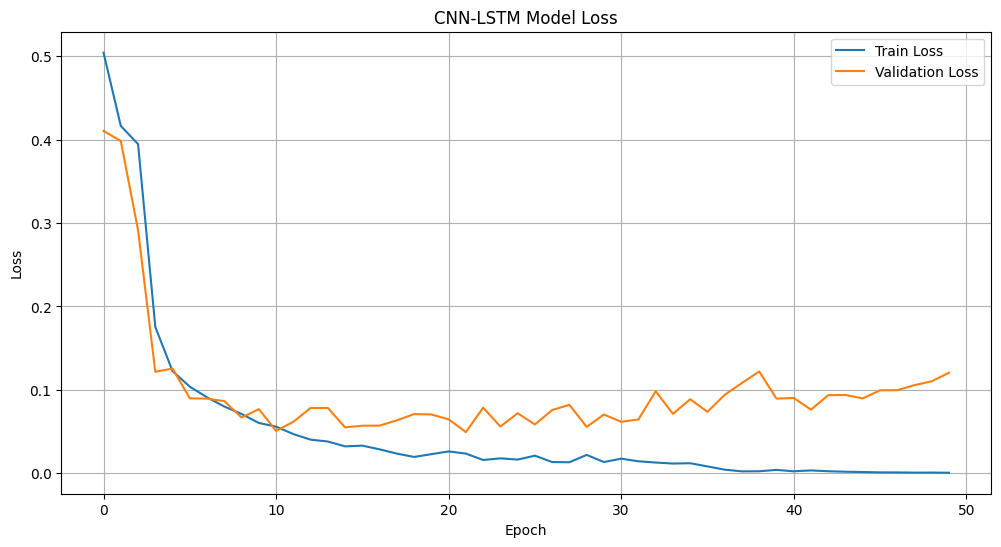

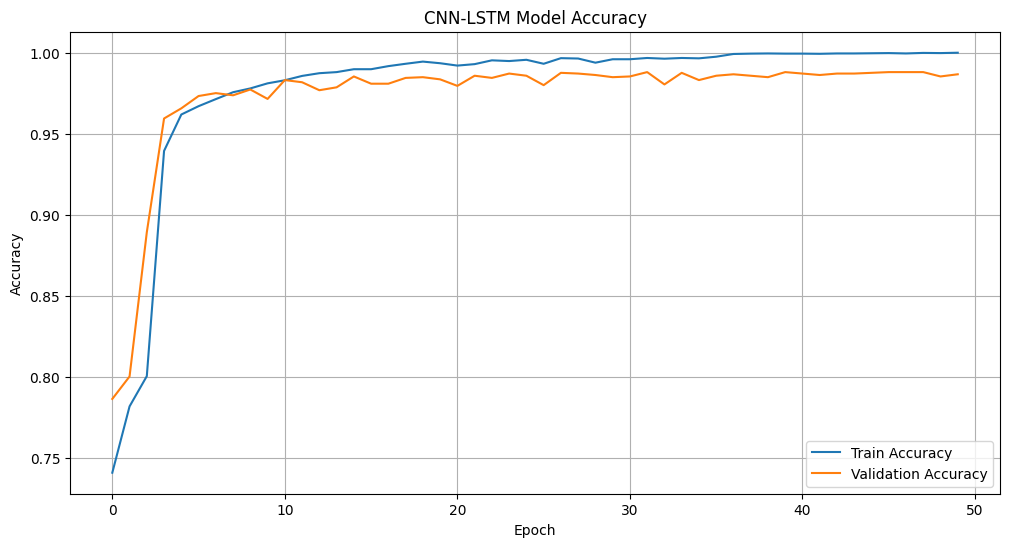

In [20]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
# predict for test set
pred=model.predict(testX)

70/70 [==============================] - 2s 12ms/step


In [22]:
model.save("../web/models/CNN-LSTM.keras")
#loaded_model = keras.models.load_model("../web/models/CNN-LSTM.keras")
#assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [23]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0


In [24]:
# Count True predicted and wrong predicted

true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2210
false prediction ::  30


In [25]:
# Number of attack and benign data in test set

attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1517
 Benign data in test set ::  723


## Confusion Matrix

In [26]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):

    accuracy = (tp+tn) / (tp+tn+fp+fn)

    return accuracy

In [27]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):

    precision = tp / (tp+fp)

    return precision

In [28]:
#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall

In [29]:
def f1_function(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


In [30]:
#Takes true values and predicted
# Returns Accuracy, precision and recall

def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
    f1 = f1_function(true_positive,false_positive,false_negative)
    
    print(f"True Positive: {true_positive}")
    print(f"True Negative: {true_negative}")
    print(f"False Positive: {false_positive}")
    print(f"False Negative: {false_negative}")
    return (accuracy,
            precision,
            recall,
            f1)

In [31]:
accuracy, precision, recall, f1= confusion_matrix(testY,pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1-score: {3} ".format(accuracy, precision, recall, f1))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Giả định testY là nhãn thực và pred là nhãn dự đoán
accuracy = accuracy_score(testY, pred)
precision = precision_score(testY, pred)
recall = recall_score(testY, pred)
f1 = f1_score(testY, pred)

print("Accuracy: {0:.4f} \nPrecision: {1:.4f} \nRecall: {2:.4f} \nF1-score: {3:.4f}".format(accuracy, precision, recall, f1))

 Accuracy : 0.9866071428571429 
 Precision : 0.9920582395764395 
 Recall : 0.988134475939354 
 F1-score: 0.9803793328973185 


In [32]:
from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill, Alignment

models = {
    "BiLSTM":2,
    "LSTM-GAP":3,
    "CNN":4,
    "CNN-LSTM":5,
    "TextCNN":6
}

file_name = "model_performance.xlsx"
try:
    wb = load_workbook(file_name)
except FileNotFoundError:
    # Nếu file không tồn tại, tạo một workbook mới
    wb = Workbook()
    sheet = wb.active
    # Đặt màu nền cho dòng header
    header_fill = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")

    # Đặt tiêu đề cho các hàng và cột
    sheet.cell(row=1, column=1).value = "Metric"
    sheet.cell(row=1, column=1).fill = header_fill
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Correct Predict", "False Predict"]
    for row, metric in enumerate(metrics, start=2):
        cell = sheet.cell(row=row, column=1)
        cell.value = metric
    
    for col, model_name in enumerate(models, start=2):
        cell = sheet.cell(row=1, column=col)
        cell.value = model_name
        cell.alignment = Alignment(horizontal="center", vertical="center")
        cell.fill = header_fill

    # Lưu file Excel mới
    wb.save(file_name)
    wb = load_workbook(file_name)

sheet = wb.active
sheet.column_dimensions['A'].width = 15
model_name = "CNN-LSTM"
col = models[model_name]
# Ghi dữ liệu của từng mô hình vào cột tương ứng

sheet.cell(row=2, column=col).value = f"{accuracy*100:.2f}%"
sheet.cell(row=2, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=3, column=col).value = f"{precision*100:.2f}%"
sheet.cell(row=3, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=4, column=col).value = f"{recall*100:.2f}%"
sheet.cell(row=4, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=5, column=col).value = f"{f1*100:.2f}%"
sheet.cell(row=5, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=6, column=col).value = true
sheet.cell(row=6, column=col).alignment = Alignment(horizontal="center", vertical="center")
sheet.cell(row=7, column=col).value = false
sheet.cell(row=7, column=col).alignment = Alignment(horizontal="center", vertical="center")

# Lưu file Excel sau khi thêm dữ liệu
wb.save(file_name)
